# Homework 4 - Applied Machine Learning

This notebook corresponds the Homework 4. Firsly, we are going to explore and clean the data we have. Then, we are going to process some Machine Learning on these data.

We are going to work with the data from the CrowdstormingDataJuly1st.csv file, which represent all players playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees that these players played under in their professional career. Each row of the tables is a dyad containing information about a player given by a specific referee (for example the number of yellow cards given by this referee to the player) and also some statistics about racial bias in the referee's home country.


Our objectif is to determine the skin color of a player depending on its characteristics. In the first part, we are going to do some supervised machine learning by training a classifier. The second task will consist in processing some unsuppervised machine learning by clustering the data. 

### Imports

We start with the usual imports

In [1]:
import pandas as pd                                     # for dealing with csv import
import numpy as np                                      # arrays and other matlab like manipulation
import os                                               # for joining paths and filenames sensibly
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import scipy.stats.mstats as ssm                        # for bootstrap
from scipy.stats import gaussian_kde as kde
import random

%matplotlib inline
import seaborn as sns                                   # For pretty plots

### Uploading the data

In [2]:
filename = 'CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)

# 0. Data Exploration and cleaning

Let's observe our data structure. First we see that we have 146028 initial rows with 28 parameters each.

In [3]:
df.shape

(146028, 28)

The 10 first parameters of the lines 100 to 105 are shown bellow. (We look at the parameters in two tables for better vizualisation)

In [4]:
df.head()
df.ix[100:105,:12]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats
100,fousseni-diawara,Fousseni Diawara,AC Ajaccio,France,28.08.1980,183.0,71.0,NaN,1,0,1,0
101,franck-signorino,Franck Signorino,Stade Reims,France,19.09.1981,173.0,69.0,Left Fullback,2,2,0,0
102,francois-marque,François Marque,SC Bastia,France,31.07.1983,187.0,85.0,Center Back,2,0,1,1
103,frederic-duplus,Frédéric Duplus,FC Sochaux,France,07.04.1990,175.0,66.0,Left Fullback,1,0,1,0
104,frederic-sammaritano,Frédéric Sammaritano,AC Ajaccio,France,23.03.1986,162.0,61.0,NaN,6,1,3,2
105,gael-angoula,Gaël Angoula,SC Bastia,France,18.07.1982,177.0,75.0,NaN,1,1,0,0


In [5]:
df.ix[100:105,12:]

,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
100,0,0,0,0,18905.jpg,0.75,1.00,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
101,0,0,0,0,11653.jpg,0.00,0.00,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
102,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
103,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
104,0,0,0,0,124957.jpg,0.25,0.25,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
105,0,0,0,0,NaN,NaN,NaN,7,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586


The parameters *rater1* and *rater2* are skin rating of the player photo given by two differents raters (5-point scale ranging from “very light skin” (0.00 value) to “very dark skin” (1.00 value)).

We observe that there are some NaN values for rater1 and rater2. In these cases, no picture was available for this player. The correlation seems obvious because the raters used the player photo to determine its skin color, but let's verify it:

In [6]:
notRatedAtAll = (df.rater1.isnull() & df.rater2.isnull())
partiallyRated = (df.rater1.isnull() | df.rater2.isnull())
photoMissing = df.photoID.isnull()

print("Both rates missing iff one rate missing: {}".format( all(notRatedAtAll == partiallyRated)))

print("Photo missing iff rating missing: {}".format( all(notRatedAtAll == photoMissing)))

Both rates missing iff one rate missing: True
Photo missing iff rating missing: True


Our objectif is to determine the skin color of a player depending on its characteristics with the use of a classifier. Therefore, the players for which we don't have any information on their skin color will not be interesting for us. We can therefore drop theses specific rows.

Let's check how many rows is concerned by this lack of information

In [7]:
(df.photoID.isnull()).sum()

21407

In [8]:
df.shape

(146028, 28)

In [9]:
(df.photoID.isnull()).sum()/df.shape[0]*100

14.659517352836444

Therefore, more or less 14.7% of our data are concerned by this lack, but we don't have any other choice that drop them because theses rows do not bring us more information.

In [10]:
df = df[(df.photoID.isnull() == False)]
df.shape

(124621, 28)

Let's check if we correctly removed all the NaNs for the rater1 and rater2 parameters

In [11]:
df.isnull().any()

playerShort      False
player           False
club             False
leagueCountry    False
birthday         False
height            True
weight            True
position          True
games            False
victories        False
ties             False
defeats          False
goals            False
yellowCards      False
yellowReds       False
redCards         False
photoID          False
rater1           False
rater2           False
refNum           False
refCountry       False
Alpha_3           True
meanIAT           True
nIAT              True
seIAT             True
meanExp           True
nExp              True
seExp             True
dtype: bool

Note also that we don't need the the parameter photoID anymore, so we can drop it:

In [12]:
df = df.drop(['photoID'], axis=1)

Here, we have an other problem. For many entries (28907, i.e 23%), the two raters do not give us similar result.

In [13]:
(df.rater1 != df.rater2).sum()

28907

In [14]:
(df.rater1 != df.rater2).sum() / df.shape[0] * 100

23.195930059941745

In order to counter this issue, we can take the euclidian mean value between the two rates of each row. Let's observe that the mean value representes correctly the situation. Let's calculate the mean rate for each column and the difference between the two rates to see if sometimes the raters give opposite results.

In [15]:
ratingsDf = df[['rater1', 'rater2']].copy()

# Computing the mean
ratingsDf['avgRate'] = (ratingsDf['rater1'] + ratingsDf['rater2']) / 2

# Computing the difference
ratingsDf['diffRate12'] = ratingsDf['rater1'] - ratingsDf['rater2']

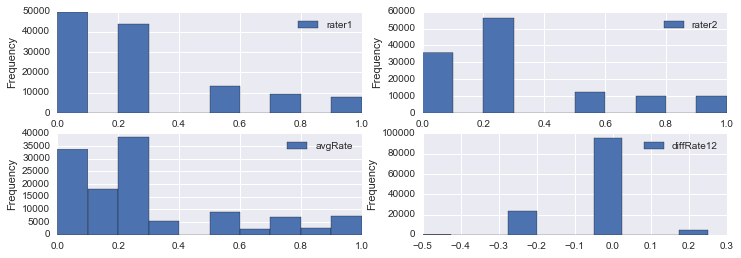

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))

ratingsDf[['rater1']].plot.hist(ax=axes[0][0])
ratingsDf[['rater2']].plot.hist(ax=axes[0][1])
ratingsDf[['avgRate']].plot.hist(ax=axes[1][0])
ratingsDf[['diffRate12']].plot.hist(ax=axes[1][1]);

Firstly, we observe that most of the time, when the raters give different result, their values are only separated by 0.25, which means that the computing the mean rates should be consitent to represent the data. This is confirmed if we take a look at the average rate histogram. It looks very similar to the two rates histogram. In order to confirm that, let's get a look at the correlation matrix:

In [17]:
ratingsDf.corr()

,rater1,rater2,avgRate,diffRate12
rater1,1.000000,0.923467,0.980837,0.215314
rater2,0.923467,1.000000,0.980523,-0.175843
avgRate,0.980837,0.980523,1.000000,0.020925
diffRate12,0.215314,-0.175843,0.020925,1.000000


We see that the correlation of the *avgRate* is very high for both raters. Therefore, let's replace rater1 and rater2 values by their mean in our data and use it for further analysis.

In [18]:
# We create a new column in our data set with the mean value
df['avgRate'] = ratingsDf[['avgRate']]

# Remove the columns of rater1 and rater2
df = df.drop(['rater1', 'rater2'], axis=1)

In [19]:
df.head(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,avgRate
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000


We are interested by determing the skin color of each player. Therefore, we need to regroup the entries by player, applying the mean on each values, excluding the number of games for which we sum them (for obvious reasons). We also add two new features *stdIAT* and *stdExp*, which are the standard deviation of meanIAT and meanExp.

In this case, the attributes *reNum*, *refCountry*, *nIAT*, *nExp* do not make any sense, and we can drop them. We are also going to drop *seIAT* and *seExp* parameters.

In [20]:
df_by_player = df.groupby("playerShort")
df_players = df_by_player.agg({'height': np.mean, 'weight':np.mean, 'games': np.sum, 'victories': np.mean, 'ties': np.mean, 'defeats': np.mean, 'goals': np.mean,
                       'yellowCards': np.mean, 'yellowReds': np.mean, 'redCards': np.mean, 'meanIAT': np.mean, 'meanExp': np.mean, 'avgRate': np.mean})

# Adding the two new features: 'stdIAT' and 'stdExp'
df_players[['stdIAT','stdExp']] = df_by_player['meanIAT', 'meanExp'].agg(np.std)

df_players.head()

,height,redCards,games,goals,avgRate,ties,defeats,meanExp,yellowReds,yellowCards,meanIAT,weight,victories,stdIAT,stdExp
playerShort,,,,,,,,,,,,,,,
aaron-hughes,182.0,0.000000,654,0.054217,0.125,1.078313,1.373494,0.494575,0.000000,0.114458,0.346459,71.0,1.487952,0.031511,0.231113
aaron-hunt,183.0,0.010101,336,0.626263,0.125,0.737374,1.232323,0.449220,0.000000,0.424242,0.348818,73.0,1.424242,0.022432,0.174013
aaron-lennon,165.0,0.000000,412,0.306931,0.250,0.960396,1.138614,0.491482,0.000000,0.108911,0.345893,63.0,1.980198,0.028438,0.224068
aaron-ramsey,178.0,0.009615,260,0.375000,0.000,0.403846,0.653846,0.514693,0.000000,0.298077,0.346821,76.0,1.442308,0.032460,0.248885
abdelhamid-el-kaoutari,180.0,0.054054,124,0.027027,0.250,1.081081,1.162162,0.335587,0.108108,0.216216,0.331600,73.0,1.108108,0.045723,0.242213


In [21]:
df_players.shape

(1585, 15)

We observe that we have a total of 1585 football players in our data. Note also that we still have some entries filled with NaN. Let's drop them.

In [22]:
df_players.isnull().any()

height          True
redCards       False
games          False
goals          False
avgRate        False
ties           False
defeats        False
meanExp        False
yellowReds     False
yellowCards    False
meanIAT        False
weight          True
victories      False
stdIAT          True
stdExp          True
dtype: bool

In [23]:
df_players = df_players[(df_players.height.isnull() == False)]
df_players = df_players[(df_players.weight.isnull() == False)]
df_players.fillna(value=0.0, inplace=True)

In [24]:
df_players.isnull().any()

height         False
redCards       False
games          False
goals          False
avgRate        False
ties           False
defeats        False
meanExp        False
yellowReds     False
yellowCards    False
meanIAT        False
weight         False
victories      False
stdIAT         False
stdExp         False
dtype: bool

In [25]:
df_players.shape

(1564, 15)

We observe now that we have 1564 players left in our *cleaned* data set.

# 1. Supervised Machine Learning - Random Forest

Now that we have made some preprocessing on the data set and keep the useful parameters for our analysis, we can start performing some Maching Learning. We will use a Random Forest classifier. The following materials are helpful to understand the tool *scikit* we are using.

https://github.com/justmarkham/scikit-learn-videos

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

We import the library:

In [26]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from plot_learning_curve import *
import warnings

/Users/loicveyssiere/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The random forest classifier seems appropriate to use in our case, because we don't know much about our data.

We cite Wikipedia because we think it captures well the spirit of our approach:



> *Decision trees are a popular method for various machine learning tasks. Tree learning "come[s] closest to meeting the requirements for serving as an off-the-shelf procedure for data mining", say Hastie et al., because it is invariant under scaling and various other transformations of feature values, is robust to inclusion of irrelevant features, and produces inspectable models. However, they are seldom accurate.[3]:352
In particular, trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets, i.e. have low bias, but very high variance. Random forests are a way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance.[3]:587–588 This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.*

Before doing any further anaylsis, it is important to say that there is two differents approach on how to train the classifier. 
* The first idea would be to train the model with the labels $y_{avg}$ determined using the average rate of skin darkness (average number between *rater1* and *rater2*). **It is the method we are going to use for the rest of the exercise**. It seems to be a good method because we have no other way to verify which of the raters are giving the right result.
* The second approach would be to separately fit two models to *rater1* and *rater2*, apply each model to new input data, and to take the average rating in the end. However, this claims that *rater1* and *rater2* have different characteristics. Fitting the models on the data where half of the raters were interchanged would lead to different models, which is not ideal.

First of all, we need to change the labels to discrete values, because we use a random forest classifier. Let's say that if a player has an average rate *avgRate* over or equal to 0.5, we will consider that his skin is dark. Otherwise, we will say that the player is white. Therefore, we can assign a label for each player:
* 0 for white player
* 1 for black player


In [27]:
def defining_skin_color(x):
    if(x['avgRate'] < 0.5):
        return 0
    else:
        return 1

In [28]:
df_players['skin color'] = df_players.apply(defining_skin_color, axis=1)

Let's now compute the number of *black* players in our data:

In [29]:
df_players['skin color'].sum()

378

In [30]:
df_players.shape[0]

1564

In [31]:
df_players['skin color'].sum() / df_players.shape[0] * 100

24.168797953964194

We observe that more or less 25% of the players (378) are considerated as black. Therfore the two classes (black and white people) do not have the same importance or representation number in the data, i.e the distribution is highly screwed. This can be a big issue when we training the model.

## Selection of Random forsest parameters : number of estimation & max of depth

The Ramdom Forest classifier depends on 2 parameters, number of estimation and max of depth. In this part we will analyse their impacts on the results by performing on each pair of parameter a cross-validation. We then visualize the means and the standard deviation, in order to choose the most suitable couple. We want to avoid overfitting. Let's consider all the parameters for this step.

In [32]:
all_parameters = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards', 'meanIAT', 'meanExp', 'stdIAT', 'stdExp']

In [33]:
# Initialization of the features and labels we are going to use in our analysis
parameters = all_parameters
X = df_players[parameters]
y = df_players['skin color']

# We partition the data in 20 folds
cv = 20

# We will test estimators from 10 to 110 and maximum depth of 1 to 8
n_estimators = np.arange(10, 110, 10)
max_depth = np.arange(1, 8, 1)

Let's define a function *parameter_analysis* that perform a cross-validation for each random forest parameters: number of estimators and max_depth. With the result obtained for each cross-validation, we will observe when the model overfit the data by analyzing the means and the standard deviations for each number of estimators and each maximum depth used. In order to visualize correctly the results, we plot them with the use of the *plotting_analysis* function.

In [34]:
# parameter_analysis will perform a cross validation for each random forest parameters n_estimators and max_depth
# passed in argument, on the features X with the labels y passed in argument as well. It returns the mean accuracy 
# of prediction and the standard deviation of each cross-validation made.
def parameter_analysis(X, y, n_estimators, max_depth, cv, scoring='accuracy'):
    
    # Result storage
    means = [[0 for i in n_estimators] for j in max_depth]
    stds = [[0 for i in n_estimators] for j in max_depth]

    # Loop over number of estimators 
    for (i, estim) in enumerate(n_estimators):

        print('Work in progress {p} %'.format(p=i/len(n_estimators)*100))

        # Loop over depth of trees
        for (j, depth) in enumerate(max_depth):

            # Builing the classifier and processing the cross-validation
            classifier = RandomForestClassifier(n_estimators=estim, max_depth=depth)
            classifier.fit(X, y)
            cross_validation = cross_val_score(classifier, X, y, cv=cv, scoring=scoring)
            means[j][i] = np.mean(cross_validation)
            stds[j][i] = np.std(cross_validation)
    print('End of Work')
    return means, stds

In [35]:
# plotting_analysis is a function that plot the means and the standard deviations of the cross-validation
# passed in parameter, for each number of estimators and each maximum depth used.
def plotting_analysis(means, stds):
    
    # Plotting means
    im = plt.imshow(means, interpolation='nearest', cmap='seismic', aspect='auto',origin='lower',extent=(n_estimators.min(),n_estimators.max(),max_depth.min(),max_depth.max()))
    plt.colorbar(im, orientation='vertical')
    plt.ylabel('Max depth',{'fontsize':16})
    plt.xlabel('n_estimators',{'fontsize':16})
    plt.title('Mean Scores', {'fontsize':20})
    plt.show()

    # Plotting standard deviations
    im = plt.imshow(stds, cmap='BrBG', interpolation='nearest', aspect='auto',origin='lower',extent=(n_estimators.min(),n_estimators.max(),max_depth.min(),max_depth.max()))
    plt.colorbar(im, orientation='vertical')
    plt.ylabel('Max depth',{'fontsize':16})
    plt.xlabel('n_estimators',{'fontsize':16})
    plt.title('Standard Deviations', {'fontsize':20})
    plt.show()

**Note:** The following cell takes a few minutes (~5 minutes) to compute.

In [36]:
means, stds = parameter_analysis(X, y, n_estimators, max_depth, cv)

Work in progress 0.0 %
Work in progress 10.0 %
Work in progress 20.0 %
Work in progress 30.0 %
Work in progress 40.0 %
Work in progress 50.0 %
Work in progress 60.0 %
Work in progress 70.0 %
Work in progress 80.0 %
Work in progress 90.0 %
End of Work


Let's take a look at the results obtained with intuitive vizualitions:

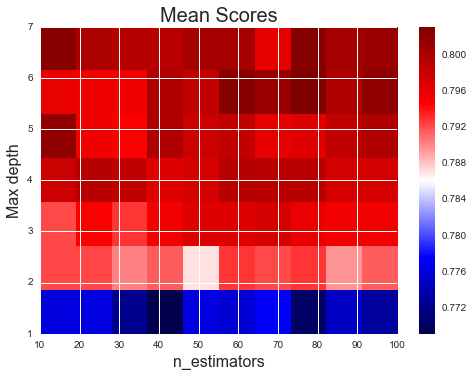

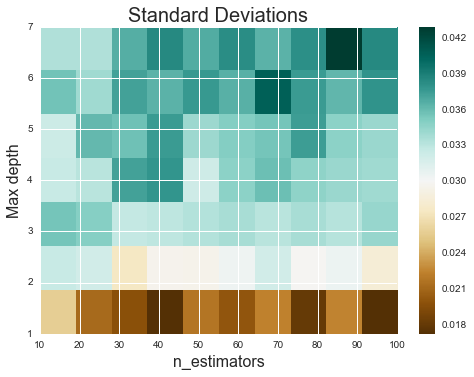

In [37]:
plotting_analysis(means, stds)

The previous plots represents means and standard deviation of each pair of parameter. The results are between 0.77 qnd 0.81 which is not a large range. Therefore, we can note that the final result is not too much influenced by the random forest parameters. We observed as well that the **best results** are obtained for a **large depths**. However, for this values, a large standard deviation is observed, which means that we are probably overfitting our data. This means that we should used small maximum depth even if the result are worst, in order to avoid a dangerous overfitting. Moreover, we observe that the number of estimators does not seem to have a revelant impact on the results.

Therefore, for the model construction with a random forest classifier, we will use the following parameters for the rest of the homework, in order to avoid overfitting:
* n_estimators = 10
* max_depth = 2

## Random forest classifier and cross-validation

Now that we have setted the random forest parameters, let's start training our random forest classifier with the simplest parameters possible, say *height* and *weight* of the players. We train and test on the whole data set.

In [38]:
# Function that train a random forest classifier with the specific parameters passed in argument. 
# It returns the training data set X, the labels y, the prediction y_pred and the classifier used.
def random_forest_predict(df, parameters, n_estim=10, max_dep=2):
    X = df[parameters]
    y = df['skin color']
    classifier = RandomForestClassifier(n_estimators=n_estim, max_depth=max_dep)
    classifier.fit(X,y)

    y_pred = classifier.predict(X)
    return X, y, y_pred, classifier

In [39]:
parameters = ['height', 'weight']
X, y, y_pred, classifier = random_forest_predict(df_players, parameters)

print('The accuracy is {0:.1f}%'.format(metrics.accuracy_score(y, y_pred)*100))

The accuracy is 76.1%


We obtain an accuracy around 76% which seems to be a good first prediction. However, we need to be careful with this result, because first the reslut may be bias: we trained and tested our model on the same data set. Secondly, 76.1% is exactly the number of white players in our data, which means that a dummy classifier that return always a constant predition would get the same accuracy.

Let's check the *y_pred* we obtained:

In [40]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
y_pred.sum()

4

We observe that our model is really bad... The classifier return the prediction 0 for (almost) all the players. This makes sense because we cannot classify skin color only with height and weight information of a person. It let us highlight the fact that **is not becaue we have good percentage accuracy that our model is good. We need to understand our data and be aware of what happens behind.**

Let observe now what happens if we add more features to train our data. We can add all the information about the player football games, say number of yellow cards he got or games he played for example. We don't take yet the parameters take concern racisim information.

In [42]:
parameters = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
X, y, y_pred, classifier = random_forest_predict(df_players, parameters)

print('The accuracy is {0:.1f}%'.format(metrics.accuracy_score(y, y_pred)*100))

The accuracy is 76.3%


In [43]:
y_pred.sum()

8

Well... we observe that it didn't influence much our previous conclusion... Let's observe what we obtained with a 20 folds cross validation in order to get rid of the bias values that we have by training and testing on the same data set.

In [44]:
cross_validation = cross_val_score(classifier, X, y, cv=20, scoring='accuracy')
cross_validation

array([ 0.75949367,  0.75949367,  0.75949367,  0.75949367,  0.75949367,
        0.75949367,  0.75641026,  0.75641026,  0.78205128,  0.75641026,
        0.75641026,  0.75641026,  0.75641026,  0.75641026,  0.75641026,
        0.74358974,  0.74358974,  0.78205128,  0.76623377,  0.77922078])

In [45]:
pd.Series(cross_validation).describe()

count    20.000000
mean      0.760249
std       0.010318
min       0.743590
25%       0.756410
50%       0.757952
75%       0.759494
max       0.782051
dtype: float64

These results seem to confirm the previous conclusion, which is that everything is classified as the same class. This can be conclude, because we have a large bias but a small variance (i.e small standard deviation).

Let's consider now all the 15 parameters and see what is going on.

In [46]:
parameters = all_parameters
X, y, y_pred, classifier = random_forest_predict(df_players, parameters)

print('The accuracy is {0:.1f}%'.format(metrics.accuracy_score(y, y_pred)*100))

The accuracy is 79.6%


In [47]:
y_pred.sum()

79

Well, something changed here. We observe that the number of found *black* players increased, but it is still not really what we expected. Let's observe what we obtained with the 20 folds cross validaition:

In [48]:
cross_validation = cross_val_score(classifier, X, y, cv=20, scoring='accuracy')
cross_validation

array([ 0.78481013,  0.82278481,  0.79746835,  0.79746835,  0.78481013,
        0.74683544,  0.79487179,  0.74358974,  0.76923077,  0.80769231,
        0.74358974,  0.83333333,  0.78205128,  0.79487179,  0.79487179,
        0.78205128,  0.74358974,  0.85897436,  0.76623377,  0.79220779])

In [49]:
pd.Series(cross_validation).describe()

count    20.000000
mean      0.787067
std       0.030384
min       0.743590
25%       0.768482
50%       0.788509
75%       0.797468
max       0.858974
dtype: float64

The results confirm our expectations. We obtained a mean prediction score of more or less 80%, and a small small standard deviation. Again, the result have still a large bias and a small variance. From this results, we can conclude that the low percentage of black players in the original set influence the classifier in a wrong way. The model tends to predict all the palyer skin color as *white*.

Let's check the confusion matrix of our predictions:

In [50]:
metrics.confusion_matrix(y, y_pred)

array([[1176,   10],
       [ 309,   69]])

As expected, we observe that the results are totally bias. **We will see later a way to balanced the importance of the class proportion (with the f1 score)**.

We can observe as well the importance of each parameters and which ones have more impact in the classification. As expected, the feature *meanIAT* and *stdIAT* are the ones that influence the most the prediction, because it take into account the racisim in the countries. Therefore, this parameter change if the player is black or not. However, it is still not good enough to obtain coherent final model.

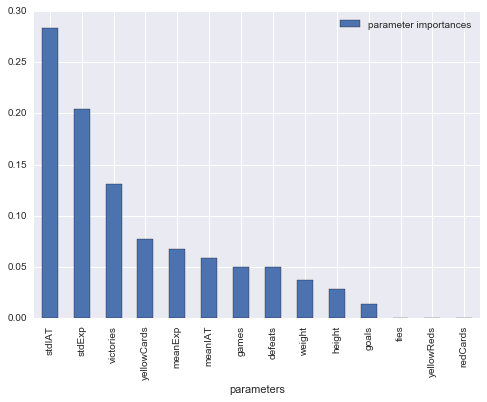

In [51]:
df_parameters_importances = pd.DataFrame({"parameters": parameters, "parameter importances": classifier.feature_importances_})
df_parameters_importances = df_parameters_importances.set_index("parameters")
df_parameters_importances = df_parameters_importances.sort_values("parameter importances", ascending=False)
df_parameters_importances.plot(kind="bar");

## F1_scoring

As stated previously, we saw that the prediction accuracy was not a good model quality measure in our case, because the percentage of balck and white players are not similar. The distribution is totally screwd. Hence, a good solution for this kind of issue is to choose the F1 score, see https://en.wikipedia.org/wiki/F1_score. The F1 score will balanced the distribution of the two classes, say the skin colors.

The goal is to prevent from the unbalanced distribution of the black & white skins. We perform again the random forest parameters analysis to see the impact of use of the **F1 score option**:

Let's compute the mean and the standard deviation of the prediction changing the parameters, but with the use of the F1 score this time.

In [52]:
# Initialization of the features and labels we are going to use in our analysis
parameters = all_parameters
X = df_players[parameters]
y = df_players['skin color']

# We partition the data in 20 folds
cv = 20

# We will test estimators from 10 to 110 and maximum depth of 1 to 8
n_estimators = np.arange(10, 110, 10)
max_depth = np.arange(1, 8, 1)

In [53]:
warnings.filterwarnings('ignore')
means, stds = parameter_analysis(X, y, n_estimators, max_depth, cv, scoring='f1_weighted')

Work in progress 0.0 %
Work in progress 10.0 %
Work in progress 20.0 %
Work in progress 30.0 %
Work in progress 40.0 %
Work in progress 50.0 %
Work in progress 60.0 %
Work in progress 70.0 %
Work in progress 80.0 %
Work in progress 90.0 %
End of Work


We plot the result obtained:

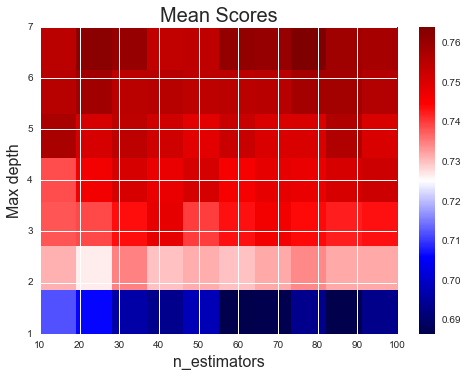

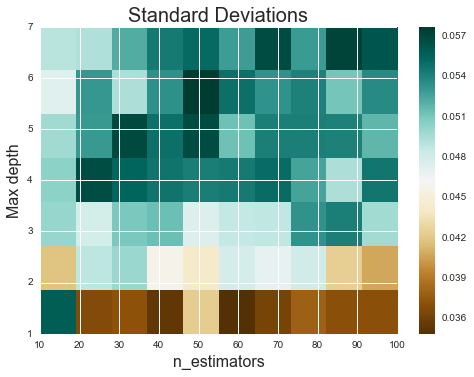

In [54]:
plotting_analysis(means, stds)

We observe a deterioration of the results (between 0.69 and 0.76). The accuracy of every model trained dropped! This is due to the fact that we considered with similar weights the importance of the 2 classes in our data, and therefore  prevented the classifier to classify every player in white in order to obtain a high score (just because there is many white player in our data).

We can verify this conclusion by doing a 20 folds cross-validation with the same random forest parameters used previously, say *n_estimators = 10* and *max_depth = 2*.

In [55]:
parameters = all_parameters
X, y, y_pred, classifier = random_forest_predict(df_players, parameters)

warnings.filterwarnings('ignore')
cross_validation = cross_val_score(classifier, X, y, cv=20, scoring='f1_weighted')
pd.Series(cross_validation).describe()

count    20.000000
mean      0.727034
std       0.049427
min       0.638746
25%       0.710185
50%       0.732526
75%       0.745921
max       0.836260
dtype: float64

We observe that the mean accuracy has dropped (around 71% now) and the variance (i.e standard deviation) has increased. We can also check the confusion matrix for this case.

In [56]:
metrics.confusion_matrix(y, y_pred)

array([[1173,   13],
       [ 305,   73]])

We observe that the number of reconized black player is a bit better, but many white player have been assigned to the wrong class (i.e misclassified). The **F1 score option is actually essential**, because it protects us to have a *dummy* classifier that just classify all the player as white. Therefore, with a new data set with more black players, the predictions of such model will be better than the *dummy* one even if there are lower in this example!

Let's check the now the features importances:

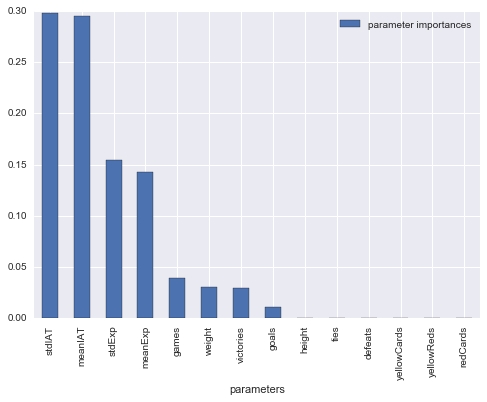

In [57]:
df_parameters_importances = pd.DataFrame({"parameters": parameters, "parameter importances": classifier.feature_importances_})
df_parameters_importances = df_parameters_importances.set_index("parameters")
df_parameters_importances = df_parameters_importances.sort_values("parameter importances", ascending=False)
df_parameters_importances.plot(kind="bar");

We observe now that the *stdExp*, *stdIAT* and *meanIA* features have much more impact than the others, which is normal, because it is the parameter that should differ between black and white players.

# 1.1 Bonus: Learning curves

The previous analysis make possible to find two different couples of parameter. One couple with test results close to train results and the other one with large bias.

In [58]:
train_sizes = np.linspace(0.2,1,20)

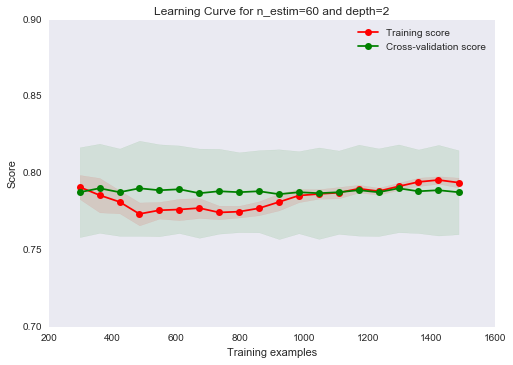

In [59]:
n_estimators = 60
max_depth = 2
estimator = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
title = 'Learning Curve for n_estim={} and depth={}'.format(n_estimators, max_depth)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 0.9), cv=20, train_sizes=train_sizes);

The previous analysis show that max_depth to 2 is a good tradeoff between good results and no overfitting. This learning curve highlight this conclusion: the training score fit the cross-validation score.

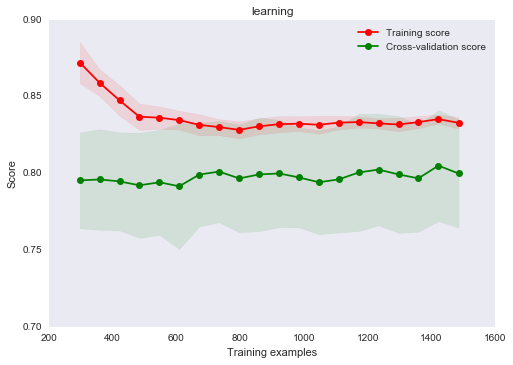

In [60]:
n_estimators = 40
max_depth = 6
estimator = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
title = 'Learning Curve for n_estim={} and depth={}'.format(n_estimators, max_depth)
plot_learning_curve(estimator, 'learning', X, y, ylim=(0.7, 0.9), cv=20, train_sizes=train_sizes);

As explained, overfitting is present with a large max_depth parameter, in this example we set max_depth to 6. Overfitting is observed since training score is not even present in the confidence interval of the cross-validation score.

# 2. Unsupervised Machine Learning - Clustering

Now that we have made some analysis and defined models using supervised Machine Learning technique, we can do another approach in order to separate the black and white palyers with the data that we have.

Let's do some unsupervised machine learning, which will consiste in trying to build two different clusters, say the dark skin players and the white skin players. We will use the **k-means clustering method**.

In [61]:
# Useful import
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Let's now use an unsupervised classifier. The goal is to define if the classification performed fits the skin color.

To compute the score of the classifier knowning the skin color of the players, the following heuristic has been set up:
    * We count the number equal labels (i.e count the number of y == prediction)
    * The score is normalized with the number of players
    * Since the classifier has no idea of what is black or white (0 or 1), the score can be flipped!
    * The final score is given by max(score, 1-score)

In [62]:
# The following function perfom a k-means clustering method on data features X passed in argument
def perform_kmean(X):
    
    kmeansClassifier = KMeans(n_clusters=2)
    kmeansClassifier.fit(X)
    prediction = kmeansClassifier.predict(X)
    silhouette = silhouette_score(X, prediction, metric='euclidean')
    
    auxi = (y == prediction).sum() / len(y)
    score = max(auxi, 1-auxi)
    return prediction, score, silhouette
    


Let's observe what we obtain with the use of the parameters for which we obtained the best perfomance in the previous analysis (with a random forest classifier).

In [63]:
# Initialization
parameters = all_parameters
X = df_players[parameters]
y = df_players['skin color']

In [64]:
prediction, score, silhouette = perform_kmean(X)
print('Score at {}, silhouette at {}'.format(score, silhouette))

Score at 0.5703324808184144, silhouette at 0.5939297187905805


We observe that the result are really bad. The algorithm is not able to separate correctly the two classes... the score obtained is around 57%. Knowing that the worst possible is 50%, it is a really bad result. Moreover, we observe that the silhouette number is really low as well. The silhouette value defined the separability of the clusters. If the silhouette value is equal to 1, the two clusters can be easily differenciated. If it is equal to 0, it is impossible to determine which value should belong to which cluster.

In our case, the silhouette value is more or less equal to 0.6, which makes hard to separate the two clusters.

In [65]:
def one_step_iteration_delete(parameters, df, criteria='score'):

    max_score = 0
    max_silhouette = 0
    
    # Compute k-mean for (n-1) features
    for (i ,parameter) in enumerate(parameters):
        
        subparameters = np.delete(parameters, i)
        prediction, score, silhouette = perform_kmean(df[subparameters])
        
        if ( (criteria=='score' and score > max_score) or (criteria=='silhouette' and silhouette > max_silhouette) ):
            deleted_parameter = parameter
            max_score = score
            max_silhouette = silhouette
            deleted_index = i
            
    return deleted_parameter, max_score, max_silhouette, deleted_index

def one_step_iteration_add(parameters, addParameters, df, criteria='score'):

    max_score = 0
    max_silhouette = 0
    
    # Compute k-mean for new features
    for (i, parameter) in enumerate(addParameters):
        
        subparameters = np.append(parameters, parameter)
        prediction, score, silhouette = perform_kmean(df[subparameters])
        
        if ( (criteria=='score' and score > max_score) or (criteria=='silhouette' and silhouette > max_silhouette) ):
            added_parameter = parameter
            max_score = score
            max_silhouette = silhouette
            added_index = i
            
    return added_parameter, max_score, max_silhouette, added_index

Starting from all the features, the following routine the most irrelevant feature. After printing the score and the silhouette, we reiterate the process on the remaining feature.

In [66]:
myParameters = parameters
while (len(myParameters) > 1):
    p, sc, si, i = one_step_iteration_delete(myParameters, df_players)
    print('Alter deleting {}: score at {:.4f}, silhouette at {:.4f}'.format(p, sc, si))
    myParameters = np.delete(myParameters, i)
print('Last feature: {}'.format(myParameters[0]))

Alter deleting height: score at 0.5703, silhouette at 0.5975
Alter deleting weight: score at 0.5703, silhouette at 0.6023
Alter deleting victories: score at 0.5703, silhouette at 0.6023
Alter deleting ties: score at 0.5703, silhouette at 0.6023
Alter deleting games: score at 0.5761, silhouette at 0.3881
Alter deleting defeats: score at 0.6841, silhouette at 0.4531
Alter deleting yellowCards: score at 0.6861, silhouette at 0.5964
Alter deleting yellowReds: score at 0.6861, silhouette at 0.5980
Alter deleting redCards: score at 0.6861, silhouette at 0.5996
Alter deleting meanIAT: score at 0.6861, silhouette at 0.6002
Alter deleting meanExp: score at 0.6861, silhouette at 0.6376
Alter deleting stdIAT: score at 0.6861, silhouette at 0.6386
Alter deleting stdExp: score at 0.6861, silhouette at 0.6956
Last feature: goals


Let's analyse the process:

 * Most irrelevant features are weight, games, victories, ties, defeats
 * Most relevant features are goals, stdExp, stdIAT, meanExp, meanIAT, readCards, yellowReds, yellowCards
 * A jump on the result appears after deleting defeats
 * The 8 best results are super close, that means that the last feature is dominant (here goals)
 * The best score is 0.6861 which is not high
 * The best silhouette is pretty bad, that is to say the 2 clusters are not well separeted 

In [67]:
myParameters = []
addParameters = parameters
while (len(addParameters) > 0):
    p, sc, si, i = one_step_iteration_add(myParameters, addParameters ,df_players)
    print('Alter adding {}: score at {:.4f}, silhouette at {:.4f}'.format(p, sc, si))
    myParameters = np.append(myParameters, p)
    addParameters = np.delete(addParameters, i)

Alter adding stdIAT: score at 0.7481, silhouette at 0.5907
Alter adding meanIAT: score at 0.7922, silhouette at 0.5550
Alter adding goals: score at 0.6861, silhouette at 0.6896
Alter adding yellowReds: score at 0.6861, silhouette at 0.6861
Alter adding redCards: score at 0.6861, silhouette at 0.6831
Alter adding meanExp: score at 0.6861, silhouette at 0.6341
Alter adding stdExp: score at 0.6861, silhouette at 0.5964
Alter adding yellowCards: score at 0.6841, silhouette at 0.4531
Alter adding defeats: score at 0.5767, silhouette at 0.3886
Alter adding games: score at 0.5703, silhouette at 0.6023
Alter adding height: score at 0.5703, silhouette at 0.5979
Alter adding weight: score at 0.5703, silhouette at 0.5939
Alter adding ties: score at 0.5703, silhouette at 0.5939
Alter adding victories: score at 0.5703, silhouette at 0.5939


Let's analyse the process:

 * Most irrelevant features are weight, victories, games, height, defeats
 * Most relevant features are stdIAT, meanIAT, goals, yellowReds, redCards, meanIAT, meanExp, yellowCards
 * A jump on the result also appears after adding defeats
 * The 6 best results are super close, that means that the last feature is dominant (here goals)
 * The best score is 0.6848 which is not high
 * The best silhouette is pretty bad, that is to say the 2 clusters are not well separeted 

Those two anaylsis are really similar. To sum up, the classification with respect to the skin color is dicted by the **goal feature**. We can admit that it is totally absurd to claim that it is possible to classifer skin color by number of goals...

Furthemore, score and silhouette are too low to ensure classifier players by skin color with our data.